The paper [Solving Mixed-integer Control Problems by Sum Up Rounding With Guaranteed Integer Gap](http://archiv.ub.uni-heidelberg.de/volltextserver/8384/) by Sager et al introduces a rounding strategy for control functions over time with respect to accumulated rounding error.

In this post, we want to apply Sum Up Rounding to the timing of medicine intake, in particular to the case where we would like to ramp down the dose, but it is not practical to take fractional amounts. So, rather than taking half a pill daily, we would take a whole pill every other day.

The central question is: 
> On which days should we take our medicine if we wanted to ramp down the dose linearly over a given period, say, 4 weeks?

In [1]:
using Random

using DataFrames
using VegaLite

In [2]:
"Sum Up Rounding of a sequence of continuous values between 0 and 1."
function sum_up_round(x)
    all(0.0 .<= x .<= 1.0) || error("Input must lie in [0, 1]!")
    
    result = zeros(size(x))
    sum = 0.0
    for (index, value) in enumerate(x)
        sum += value
        rounded = round(sum)
        result[index] = rounded
        sum -= rounded
    end

    @assert -1.0 <= sum <= 1.0
    @assert all(0.0 .<= result .<= 1.0)
    
    return result
end

sum_up_round

The implementation is straight-forward: We iterate over the sequence of continuous control values, round at each time step, and add the remainder (rounding error) to the running sum.

Let's apply it to some sequences to see it in effect! First, random numbers:

random = [0.236033, 0.346517, 0.312707, 0.00790928, 0.488613, 0.210968, 0.951916, 0.999905, 0.251662, 0.986666]
rounded = [0.0, 1.0, -0.0, -0.0, 0.0, 1.0, 1.0, 1.0, -0.0, 1.0]


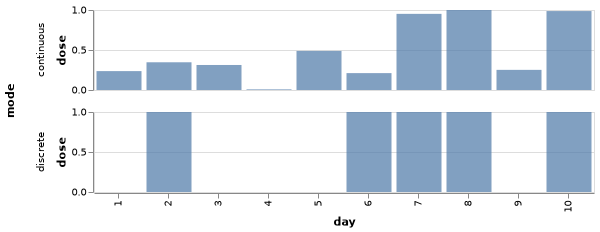

In [3]:
Random.seed!(1)

random = rand(10)
rounded = sum_up_round(random)
@show random rounded

data = vcat(DataFrame(day=1:10, dose=random, mode="continuous"),
            DataFrame(day=1:10, dose=rounded, mode="discrete"))
@vlplot(
    mark={:bar, opacity=0.7},
    height=80, width=500, data=data,
    x="day:o", y={:dose, stack=nothing}, row=:mode
)

As we can see in the above plot, we have a value of 1 on day 2 in the result, even though the original control has a value below 0.5, because the method takes into account also the values from previous results (that were rounded down).

Let's consider a wave pattern:

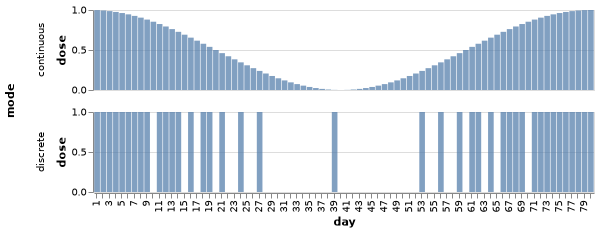

In [4]:
days = 1:80
wave = (cos.(2π/length(days) .* days) .+ 1) ./ 2
rounded = sum_up_round(wave)

data = vcat(DataFrame(day=days, dose=wave, mode="continuous"),
            DataFrame(day=days, dose=rounded, mode="discrete"))
@vlplot(
    mark={:bar, opacity=0.7},
    height=80, width=500, data=data,
    x="day:o", y={:dose, stack=nothing}, row=:mode
)

The result is not fully symmetric, but we can see a higher frequencies of 1s where the original control is relative large. Not also the value at day 39, where the original control is almost 0, but we have to correct for the rounded down values for the preceding 12 days!

Let's now answer our actual question, about the Sum Up Rounding of a ramped down medicine intake:

In [5]:
"Linear ramp down covering a given number of days."
ramp_down(length) = range(1.0, 0.0, length=length)

ramp_down

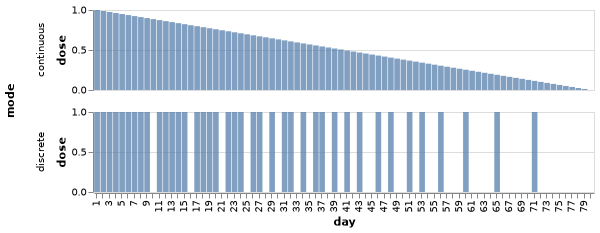

In [6]:
days = 1:80
ramp = ramp_down(length(days))
rounded = sum_up_round(ramp)

data = vcat(DataFrame(day=days, dose=ramp, mode="continuous"),
            DataFrame(day=days, dose=rounded, mode="discrete"))
@vlplot(
    mark={:bar, opacity=0.7},
    height=80, width=500, data=data,
    x="day:o", y={:dose, stack=nothing}, row=:mode
)

As expected, the frequency of 1 outputs is decreasing, but not monotonically!

Let's explore some more time windows:

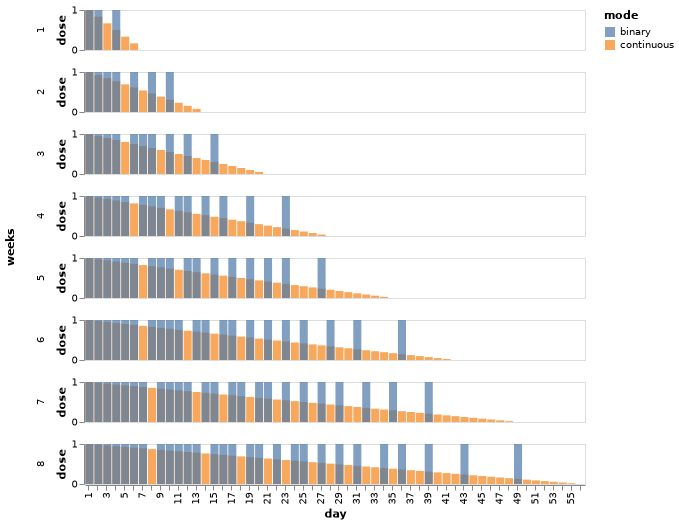

In [7]:
parts = DataFrame[]
for w in 1:8
    n = 7*w
    ramp = collect(ramp_down(n))
    push!(parts, DataFrame(weeks=w, day=1:n, mode="continuous", dose=ramp))
    rounded = sum_up_round(ramp)
    push!(parts, DataFrame(weeks=w, day=1:n, mode="binary", dose=rounded))
end
data = vcat(parts...)

@vlplot(
    mark={:bar, opacity=0.7},
    height=40, width=500, data=data,
    x="day:o", y={:dose, stack=nothing}, row="weeks:n", color=:mode
)

Finally, let's look at the case where we want to ramp down to a lower dose, say 1/3, instead of 0, and then stay there for another week.

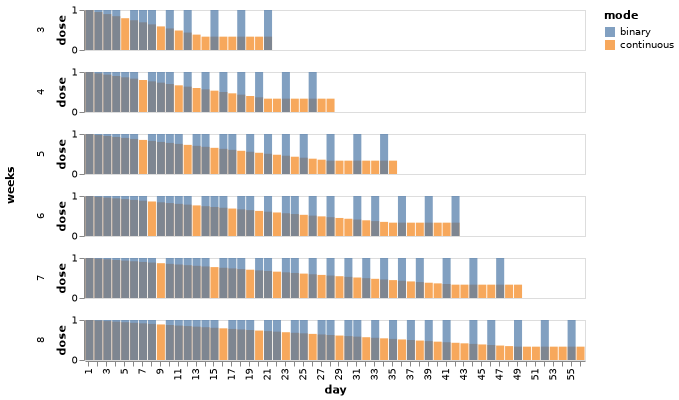

In [8]:
parts = DataFrame[]
high, low = 1, 1/3
for w in 3:8
    n = 7*w
    ramp = vcat(range(high, low, length=n - 7), repeat([low], 7)) 
    push!(parts, DataFrame(weeks=w, day=1:n, mode="continuous", dose=ramp))
    rounded = sum_up_round(ramp)
    push!(parts, DataFrame(weeks=w, day=1:n, mode="binary", dose=rounded))
end
data = vcat(parts...)

@vlplot(
    mark={:bar, opacity=0.7},
    height=40, width=500, data=data,
    x="day:o", y={:dose, stack=nothing}, row="weeks:n", color=:mode
)

Please don't mistake the above experiments for medical advice!